In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from adjustText import adjust_text

In [2]:
os.chdir("/exports/igmm/eddie/wendy-lab/elias/Friman2022/contact_screen")

In [3]:
#Download TF and cofactor lists
!wget http://bioinfo.life.hust.edu.cn/static/AnimalTFDB3/download/Homo_sapiens_TF -O Homo_sapiens_TF.txt -q
!wget http://bioinfo.life.hust.edu.cn/static/AnimalTFDB3/download/Homo_sapiens_TF_cofactors -O Homo_sapiens_TF_cofactors.txt -q

In [4]:
TFs = pd.read_csv("Homo_sapiens_TF.txt", sep="\t")
TFs["Factor"] = TFs["Symbol"].str.upper()

In [5]:
Cofactor = pd.read_csv("Homo_sapiens_TF_cofactors.txt", sep="\t")
Cofactor["Factor"] = Cofactor["Symbol"].str.upper()

In [6]:
#Load contact screen data
shortrange = pd.read_csv("GM12878.hg38.1000_hg38-cCREs_GM12878_DNase_merged5kb.bed_expected_noflank_10kbres_100kbto10Mb_stripe.clpy_hg38-cCREs_GM12878_DNase_merged5kb_cistromeDB_ReMap2020_filtered.bed_shortrange.txt", sep="\t")
longrange = pd.read_csv("GM12878.hg38.1000_hg38-cCREs_GM12878_DNase_merged5kb.bed_expected_noflank_10kbres_100kbto10Mb_stripe.clpy_hg38-cCREs_GM12878_DNase_merged5kb_cistromeDB_ReMap2020_filtered.bed_longrange.txt", sep="\t")

In [7]:
#Calculate adjusted p-values
for df in [shortrange, longrange]:
    df["adj_p"] = -np.log10(df["p_value"] * len(df["ID_Factor"].unique()))
    df["Factor"] = df.ID_Factor.str.split('_', n=1).str[1]

/exports/igmm/eddie/chr11/elias/anaconda/envs/coolpuppy_trans/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/exports/igmm/eddie/chr11/elias/anaconda/envs/coolpuppy_trans/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [8]:
combined = pd.merge(shortrange, longrange, on=["ID_Factor", "Factor"], suffixes=["_short", "_long"])

In [9]:
combined[combined["Factor"] == "RNF2"]

,ID_Factor,p_value_short,F_value_short,adj_p_short,Factor,p_value_long,F_value_long,adj_p_long


In [10]:
#Rename factors
combined["Factor"] = np.where(combined["Factor"] == "RNF2", "RING1B", combined["Factor"])
combined["Factor"] = np.where(combined["Factor"] == "POLR2A", "RPB1", combined["Factor"])

In [11]:
#Manual annotation of groups
TF = TFs["Factor"].tolist() + ["SMAD2/3", "SMAD2-3", 'ISL1-2']
Cofactors = Cofactor["Factor"].tolist() + ["ZNF143", "CFP1", "RPB1", "KMT2D", "CHD2", "SUPT5H"]
Cohesin = ['CTCF', 'SMC1A', 'RAD21', 'STAG1', 'STAG2', 'SMC3', 'WAPL', 'NIPBL']
Polycomb = ['PHC1', 'RING1B', 'RING1A', 'RING1B', 'EED', 'EZH2', 'CBX2', 'SUZ12', 
            'CBX7',  'RBP1', 'MTF2', 'PCGF2', 'RYBP', 'KDM2B', 'BAP1',
            'PCGF6', 'CBX6', 'PCGF1', 'PHF19', 'CBX8', 'JARID2', 'EPOP']
Repressive = ['CHD4', 'TRIM28', 'SINHCAF', 'TET1', 'TET3', 'SIN3A', 'DNMT3B', 
              'REST', 'HEXIM1', 'CBX1', 'CBX5', 'CBX3', 'ZMYM3']

In [12]:
combined["Group"] = "Other"
combined.loc[combined["Factor"].isin(TF),"Group"] = "TF"
combined.loc[combined["Factor"].isin(Cofactors),"Group"] = "Co-factors"
combined.loc[combined["Factor"].isin(Repressive),"Group"] = "Repressive"
combined.loc[combined["Factor"].isin(Polycomb),"Group"] = "Polycomb"
combined.loc[combined["Factor"].isin(Cohesin),"Group"] = "Cohesin"

In [13]:
combined.to_csv("GM12878_contact_screen_result.txt", sep="\t", index=False)

In [14]:
palette = {f:'whitesmoke' for f in set(combined["Factor"])}
for f in combined.loc[combined["Group"] == "TF","Factor"]:
    palette[f] = '#4daf4a' 
for f in combined.loc[combined["Group"] == "Co-factors","Factor"]:
    palette[f] = '#e41a1c' 
for f in combined.loc[combined["Group"] == "Cohesin","Factor"]:
    palette[f] = 'orange'
for f in combined.loc[combined["Group"] == "Polycomb","Factor"]:
    palette[f] = '#377eb8'
for f in combined.loc[combined["Group"] == "Repressive","Factor"]:
    palette[f] = 'cyan'

/tmp/ipykernel_234507/507689901.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90, va='top', ha="center")


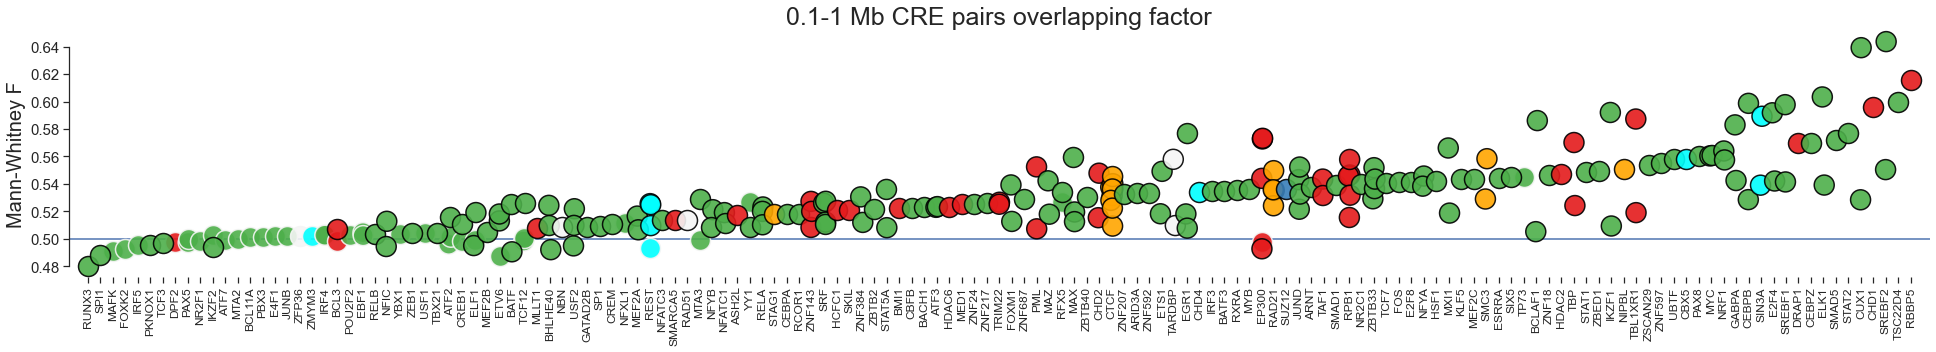

In [15]:
sns.set(style="ticks", font="Arial")
sns.set_context("notebook", rc={"font.size":1,"axes.titlesize":25, 
                                "axes.labelsize":20, "xtick.labelsize": 12,
                                "ytick.labelsize": 15})  
#Split by significance
data1 = combined[combined["adj_p_short"] < -np.log10(0.05)]
data2 = combined[combined["adj_p_short"] > -np.log10(0.05)]
order = combined.groupby('Factor')['F_value_short'].mean().sort_values().index

plt.figure(figsize=(27,5))
g = sns.stripplot(x='Factor', y='F_value_short', data=data1, 
                  alpha=0.9, s=20, palette=palette, hue="Factor", legend=False,
                  order=order, edgecolor='whitesmoke', linewidth = 1.5)
sns.stripplot(x='Factor', y='F_value_short', data=data2, 
              alpha=0.9, s=20, palette=palette, hue="Factor", legend=False,
              order=order, edgecolor='black', linewidth = 1.5, ax=g)
g.set_xticklabels(g.get_xticklabels(), rotation=90, va='top', ha="center")
plt.axhline(0.5)

g.set(title='0.1-1 Mb CRE pairs overlapping factor', 
      ylabel="Mann-Whitney F", xlabel = "",
      xlim=[g.get_xlim()[0]-1, g.get_xlim()[1]+1])

sns.despine(bottom=True, trim=True)
plt.tight_layout()
plt.savefig("./plots/GM12878_shortrange_F.svg", bbox_inches='tight')

/tmp/ipykernel_234507/1544405578.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90, va='top', ha="center")


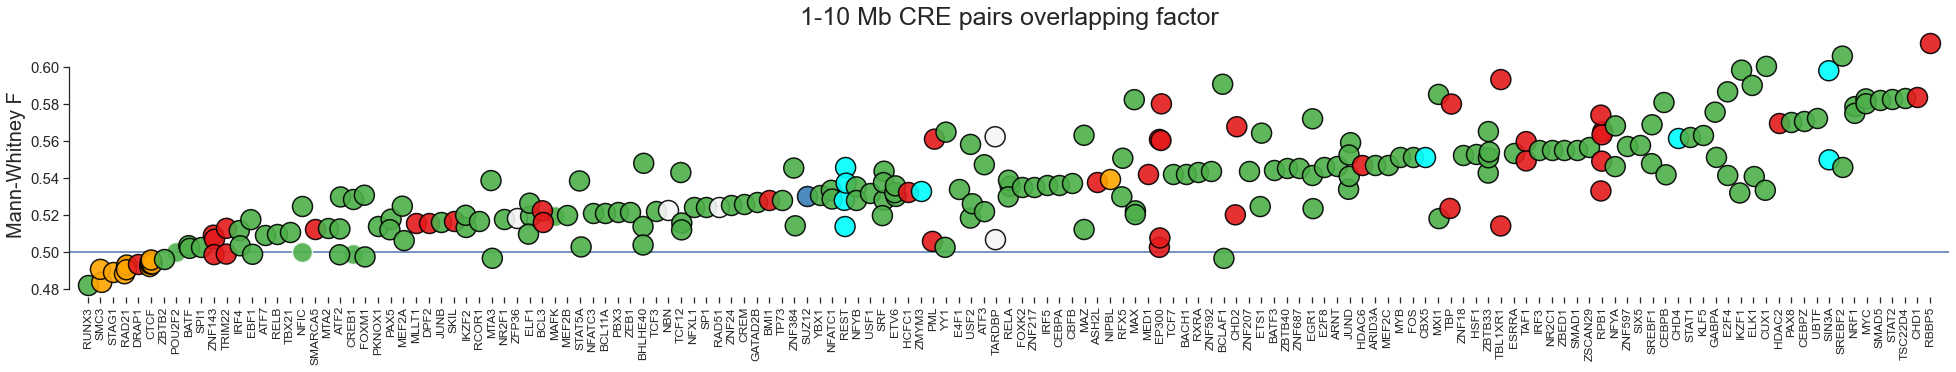

In [16]:
sns.set(style="ticks", font="Arial")
sns.set_context("notebook", rc={"font.size":1,"axes.titlesize":25, 
                                "axes.labelsize":20, "xtick.labelsize": 12,
                                "ytick.labelsize": 15})  
#Split by significance
data1 = combined[combined["adj_p_long"] < -np.log10(0.05)]
data2 = combined[combined["adj_p_long"] > -np.log10(0.05)]
order = combined.groupby('Factor')['F_value_long'].mean().sort_values().index

plt.figure(figsize=(27,5))
g = sns.stripplot(x='Factor', y='F_value_long', data=data1, 
                  alpha=0.9, s=20, palette=palette, hue="Factor", legend=False,
                  order=order, edgecolor='whitesmoke', linewidth = 1.5)
sns.stripplot(x='Factor', y='F_value_long', data=data2, 
              alpha=0.9, s=20, palette=palette, hue="Factor", legend=False,
              order=order, edgecolor='black', linewidth = 1.5, ax=g)
g.set_xticklabels(g.get_xticklabels(), rotation=90, va='top', ha="center")
plt.axhline(0.5)

g.set(title='1-10 Mb CRE pairs overlapping factor', 
      ylabel="Mann-Whitney F", xlabel = "",
      xlim=[g.get_xlim()[0]-1, g.get_xlim()[1]+1])

sns.despine(bottom=True, trim=True)
plt.tight_layout()
plt.savefig("./plots/GM12878_longrange_F.svg", bbox_inches='tight')

In [17]:
palette2 = {f:'whitesmoke' for f in set(combined["Group"])}
for f in combined.loc[combined["Group"] == "TF","Group"]:
    palette2[f] = '#4daf4a' 
for f in combined.loc[combined["Group"] == "Co-factors","Group"]:
    palette2[f] = '#e41a1c' 
for f in combined.loc[combined["Group"] == "Cohesin","Group"]:
    palette2[f] = 'orange'
for f in combined.loc[combined["Group"] == "Polycomb","Group"]:
    palette2[f] = '#377eb8'
for f in combined.loc[combined["Group"] == "Repressive","Group"]:
    palette2[f] = 'cyan'

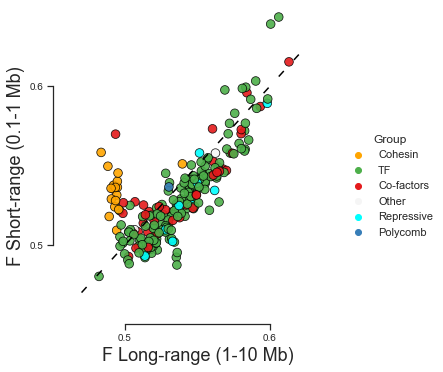

In [18]:
sns.set(style="ticks", font="Arial")
sns.set_context("notebook", rc={"font.size":1,"axes.titlesize":15, 
                                "axes.labelsize":18, "xtick.labelsize": 10,
                                "ytick.labelsize": 10}) 
#Select significant datasets
data = combined[(combined["adj_p_short"] > -np.log10(0.05)) | 
                (combined["adj_p_long"] > -np.log10(0.05))]
#Order to put Polycomb on top
idx_label = data[data["Group"] == "Polycomb"].sort_values('F_value_short', ascending=False).drop_duplicates(subset="Factor").index
idx = [i for i in range(len(data)) if i not in list(idx_label)] + list(idx_label)
data = data.iloc[idx]

g = sns.relplot(data=data, y="F_value_short", x="F_value_long", hue = "Group", legend=True,
                alpha=0.9, s=75, height = 5, aspect = 1, edgecolor='black', linewidth = 0.75, 
                palette=palette2)

g.set(title='', ylabel="F Short-range (0.1-1 Mb)", xlabel = "F Long-range (1-10 Mb)",
      xlim=[0.45, 0.65], ylim=[0.45, 0.65])
plt.xticks([0.5, 0.6])
plt.yticks([0.5, 0.6])
g.ax.plot([0.47, 0.62], [0.47,0.62], 'black', alpha=1, dashes=(5, 10))
sns.despine(trim=True, offset=0)
plt.savefig("./plots/GM12878_long_vs_short.svg", bbox_inches="tight")